In [35]:
import yfinance as yf
import ta
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
import statsmodels.api as sm
# import warnings
# warnings.filterwarnings("ignore")

import datetime
import holidays 

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [36]:
def display_metrics(df):
    # Calculating error metrics
    mse = mean_squared_error(df['Close'], df['preds'])
    print(f"Mean Squared Error (MSE): {mse:.4f}")

    rmse = mean_squared_error(df['Close'], df['preds'], squared=False)
    print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")

    mape = (abs(df['Close'] - df['preds']) / df['Close']).mean() * 100
    print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")

    bias = ((df['Close'] - df['preds']) / df['Close']).mean() * 100
    print(f"Mean Absolute Percentage Error (BIAS): {mape:.2f}%")

In [37]:
def plot_train_test(train, test):
    plt.figure(figsize=(12, 6))

    # Plot the actual close prices from train data
    sns.lineplot(x=train.index, y=train['Close'], label="Train Data (Actual Close)", color="blue")

    # Plot the actual close prices from test data
    sns.lineplot(x=test.index, y=test['Close'], label="Test Data (Actual Close)", color="green")

    # Plot the naive random walk predictions for test data
    sns.lineplot(x=test.index, y=test['preds'], label="Test Data (Predicted)", color="red", linestyle="dashed")

    # Customize labels and title
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Train vs. Test Data: Actual vs Predictions (ON TEST DATA)")
    plt.legend()

    # Show the plot
    plt.show()
    

In [38]:
def plot_oos(df_actual, df_preds):
    ## Plotting Predictions
    # Plot the actual and predicted stock prices
    plt.figure(figsize=(12, 6))

    # Plot the actual close prices
    sns.lineplot(x=df_actual.index, y=df_actual['Close'], label="Actual Close Price", color="blue")

    # Plot the naive random walk predictions
    sns.lineplot(x=df_preds['dt'], y=df_preds['preds'], label="Prediction", color="red", linestyle="dashed")

    # Customize labels and title
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.title("Actual vs. Predicted Stock Prices (OUT OF SAMPLE)")
    plt.legend()

    # Show the plot
    plt.show()

In [ ]:
data = yf.Ticker("NKE")

df = pd.DataFrame(data.history(period='max'))

##Filter to 3 years of history (if available)... else use all history
last_date = df.index[-1]
three_years_ago = last_date - pd.DateOffset(years=3)

if df.index[0] < three_years_ago:
    df_filtered = df[df.index >= three_years_ago]  # Use last 3 years
    print("Filtered to last 3 years: ", df_filtered.index.min())
else:
    df_filtered = df  # Use all data if less than 3 years
    print("Less than 3 years of data: ", df_filtered.index.min())
print(df_filtered.tail(3))
print(df_filtered[['Close']].describe())


Less than 3 years of data:  2023-06-16 00:00:00-04:00
                                Open       High        Low      Close  \
Date                                                                    
2025-03-28 00:00:00-04:00  87.059998  88.099998  84.660004  85.849998   
2025-03-31 00:00:00-04:00  82.680000  87.209999  81.739998  86.410004   
2025-04-01 00:00:00-04:00  86.235001  87.800003  84.940102  87.199997   

                             Volume  Dividends  Stock Splits  
Date                                                          
2025-03-28 00:00:00-04:00  14361000        0.0           0.0  
2025-03-31 00:00:00-04:00   4160100        0.0           0.0  
2025-04-01 00:00:00-04:00   2253279        0.0           0.0  
            Close
count  449.000000
mean    78.217595
std     36.608836
min     29.980000
25%     44.000000
50%     74.239998
75%    114.589996
max    150.880005


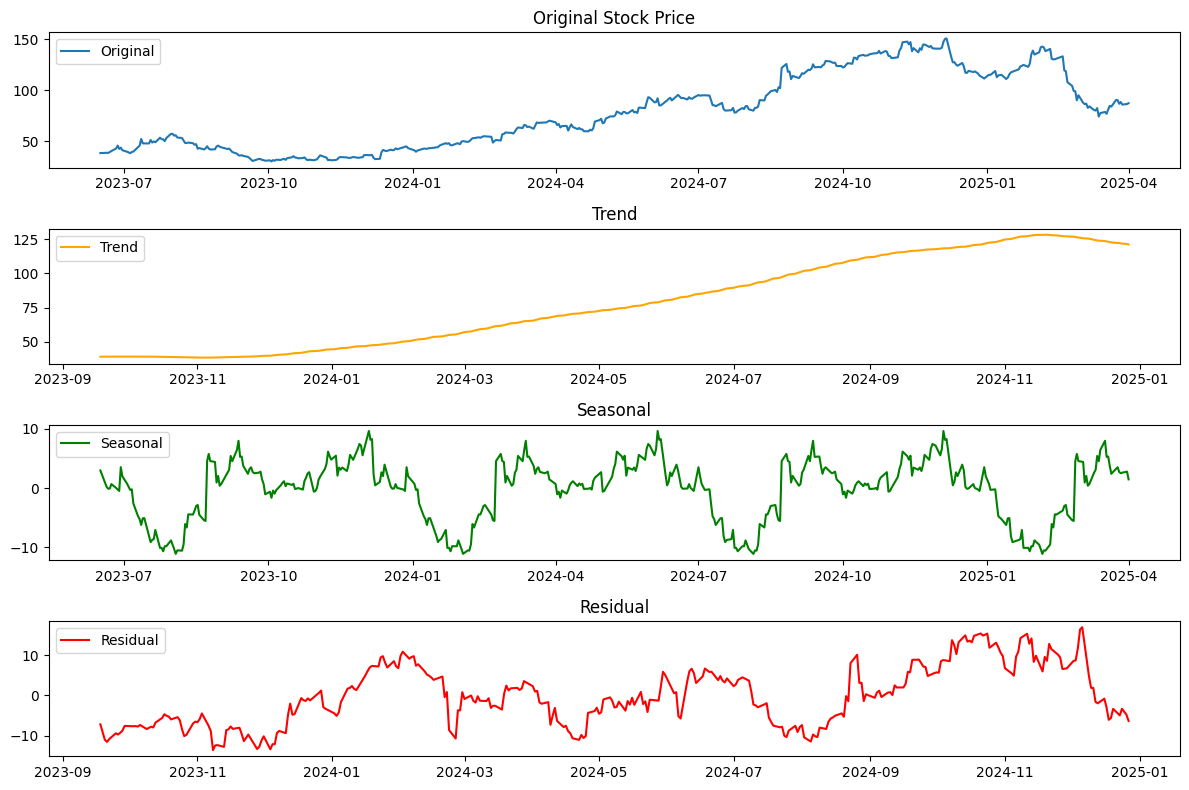

Date
2023-06-16 00:00:00-04:00    2.960668
2023-06-20 00:00:00-04:00    0.193102
2023-06-21 00:00:00-04:00   -0.116448
2023-06-22 00:00:00-04:00   -0.068340
2023-06-23 00:00:00-04:00    0.667822
Name: seasonal, dtype: float64


In [40]:
period = round(252 / 2) # Use period=252 for daily data (1 year of trading days)
result = seasonal_decompose(df_filtered['Close'], model='additive', period=period)  

# Plot the decomposition
plt.figure(figsize=(12, 8))

plt.subplot(411)
plt.plot(df_filtered['Close'], label='Original')
plt.title('Original Stock Price')
plt.legend(loc='upper left')

plt.subplot(412)
plt.plot(result.trend, label='Trend', color='orange')
plt.title('Trend')
plt.legend(loc='upper left')

plt.subplot(413)
plt.plot(result.seasonal, label='Seasonal', color='green')
plt.title('Seasonal')
plt.legend(loc='upper left')

plt.subplot(414)
plt.plot(result.resid, label='Residual', color='red')
plt.title('Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

# Extract the seasonal component
seasonality = result.seasonal

# Print out the first few values of the seasonal component
print(seasonality.head())

# Now you can use seasonality for further analysis or forecasting

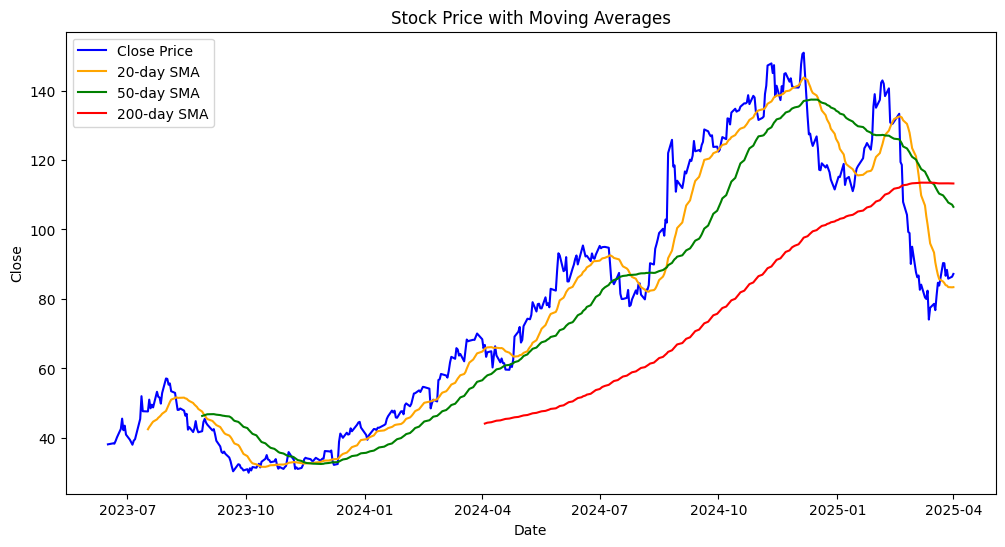

In [41]:
import seaborn as sns
import matplotlib.pyplot as plt

# Simple Moving Average (SMA)
df_filtered['SMA_20'] = df_filtered['Close'].rolling(window=20).mean()
df_filtered['SMA_50'] = df_filtered['Close'].rolling(window=50).mean()
df_filtered['SMA_200'] = df_filtered['Close'].rolling(window=200).mean()

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(x=df_filtered.index, y=df_filtered['Close'], label="Close Price", color="blue")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_20'], label="20-day SMA", color="orange")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_50'], label="50-day SMA", color="green")
sns.lineplot(x=df_filtered.index, y=df_filtered['SMA_200'], label="200-day SMA", color="red")

plt.title("Stock Price with Moving Averages")
plt.show()

## 50-day moving average (SMA) crosses above the 200-day moving average (SMA), Bullish
# 50-day moving average (SMA) crosses below the 200-day moving average (SMA), Bearish


# Begin Modeling

In [42]:
## Test Data
test_length = 30
test_data = df_filtered[["Close"]].tail(test_length).copy()
first_test_date = test_data.index[0] # To make train

# Train Data
train_data = df_filtered[df_filtered.index < first_test_date][["Close", "Volume"]].copy()



In [43]:
## Constants for Modeling

df_to_model = df_filtered[['Close', 'Volume']].copy()
predictions_df = pd.DataFrame()
last_price = df_to_model['Close'].iloc[-1]
days_of_trading_to_predict = 100


## Creating future dates to predict
us_holidays = holidays.UnitedStates(years = [2025,2026])
current_datetime = datetime.datetime.today()
current_datetime = current_datetime + datetime.timedelta(days=1)
formatted_date = current_datetime.strftime("%m/%d/%Y")
future_dates = pd.date_range(start=formatted_date, periods=days_of_trading_to_predict, freq='B')
# Remove U.S. holidays from the generated business days
future_dates = [date for date in future_dates if date not in us_holidays]

# Keep only the first `days_of_trading_to_predict` valid trading days
future_dates = future_dates[:days_of_trading_to_predict]

predictions_df = pd.DataFrame({'dt': future_dates})


## Naive Random Walk (Baseline)

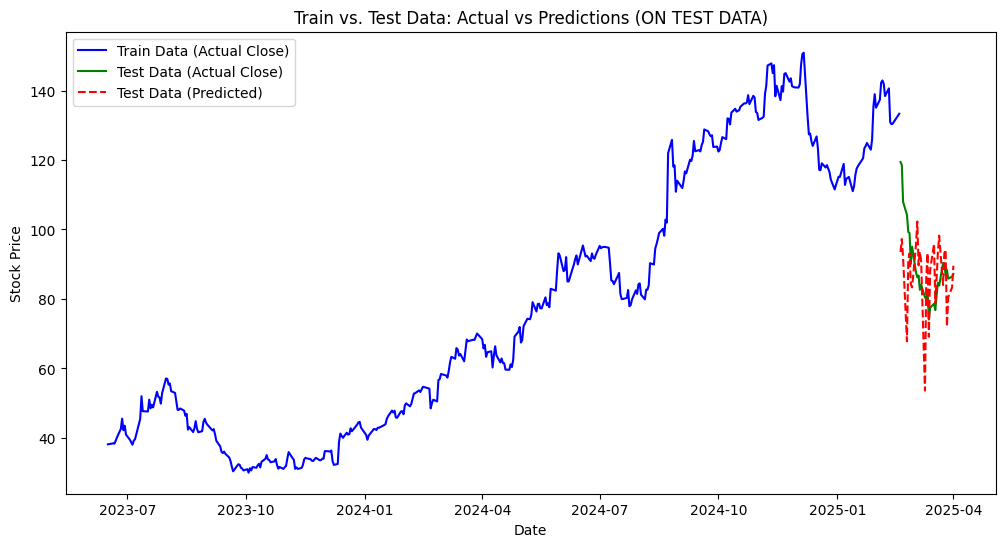

Mean Squared Error (MSE): 183.9560
Root Mean Squared Error (RMSE): 13.5630
Mean Absolute Percentage Error (MAPE): 11.93%
Mean Absolute Percentage Error (BIAS): 11.93%


In [44]:
## TEST

test_df_naive = test_data.copy()

mu = 0  # Mean return (0 for pure random walk)
std_dev = test_df_naive['Close'].std()
sigma = std_dev  # Standard deviation of returns

closes = np.random.normal(mu, sigma, len(test_data))
closes = closes + last_price

test_df_naive['preds'] = closes

plot_train_test(train_data, test_df_naive)
display_metrics(test_df_naive)

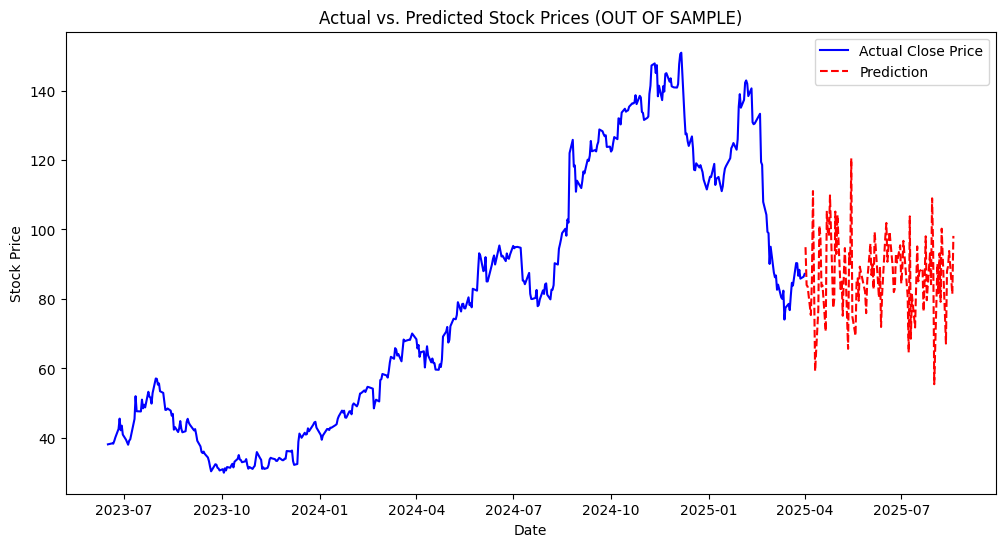

In [45]:
## OUT OF SAMPLE
predictions_df_naive = predictions_df.copy()

# Generate random walk
closes = np.random.normal(mu, sigma, len(predictions_df_naive))
std_dev = df_to_model['Close'].std()
closes = closes + last_price

predictions_df_naive['preds'] = closes


## Plotting Predictions
plot_oos(df_to_model, predictions_df_naive)

## Simple Moving Average

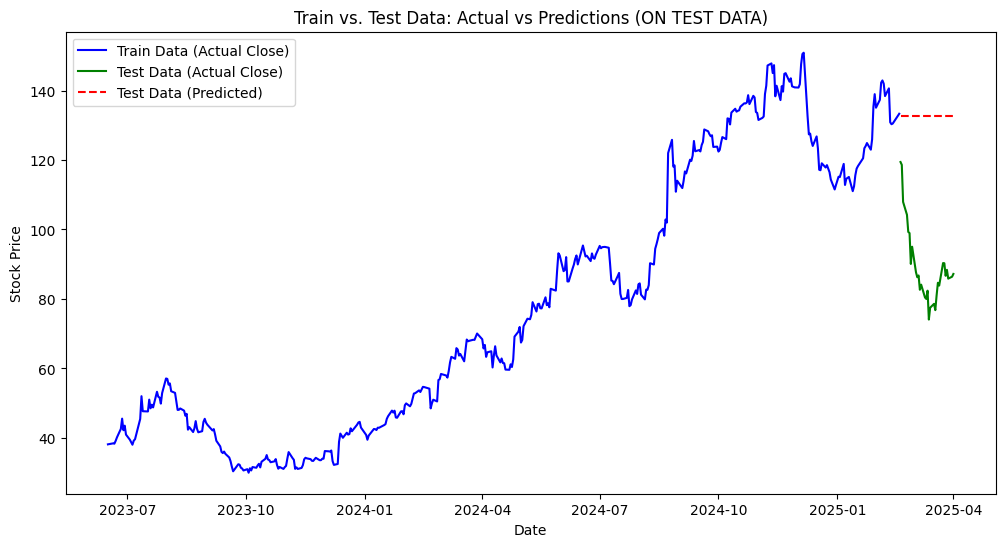

Mean Squared Error (MSE): 2001.1745
Root Mean Squared Error (RMSE): 44.7345
Mean Absolute Percentage Error (MAPE): 50.63%
Mean Absolute Percentage Error (BIAS): 50.63%


In [46]:
## TEST
test_df_ma = test_data.copy()
moving_avg_window = 20  # 20-day moving average
train_data['SMA_20'] = train_data['Close'].rolling(window=moving_avg_window).mean()

# Use the last value of the SMA as a baseline for future predictions
# We will predict that future stock prices (for test data) will follow the last known SMA value
last_sma_value = train_data['SMA_20'].iloc[-1]

# For the test data, predict using the last SMA value

test_df_ma['preds'] = last_sma_value

# Plotting actual and predicted values
plot_train_test(train_data, test_df_ma)
display_metrics(test_df_ma)


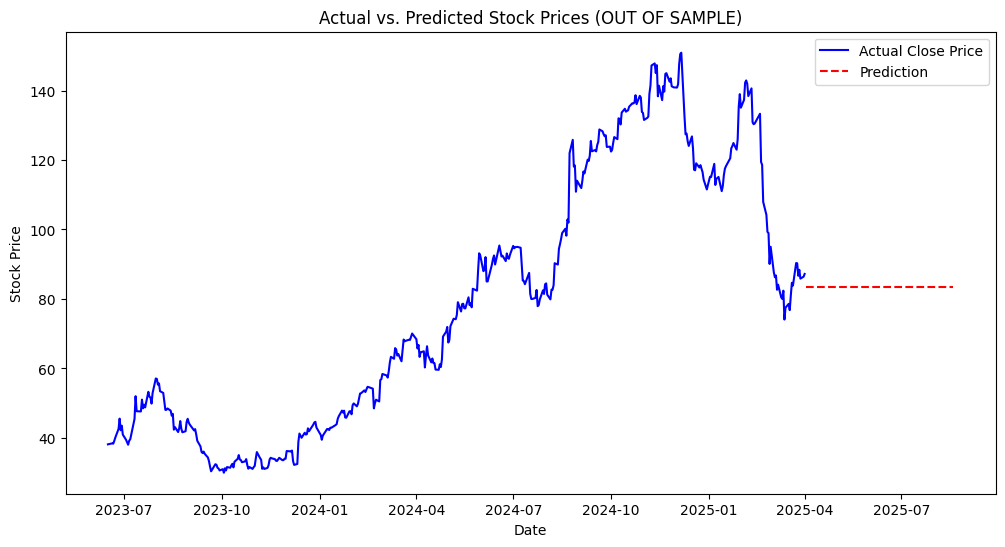

In [47]:
## OUT OF SAMPLE
predictions_df_sma = predictions_df.copy()

moving_avg_window = 20  # 20-day moving average
df_to_model['SMA_20'] = df_to_model['Close'].rolling(window=moving_avg_window).mean()
last_sma_value = df_to_model['SMA_20'].iloc[-1]

predictions_df_sma['preds'] = last_sma_value

# Plotting Predictions
plot_oos(df_to_model, predictions_df_sma)


## ARIMA

In [48]:
# ## TEST

# # Copy test data
# test_df_arima = test_data.copy()

# # Fit ARIMA model on train_data (adjust p, d, q as needed)
# model = ARIMA(train_data['Close'], order=(30, 1, 10))
# model_fit = model.fit()

# # Generate predictions for the test period
# # test_df_arima['preds'] = model_fit.forecast(steps=len(test_df_arima))
# preds = model_fit.forecast(steps=len(test_df_arima))
# test_df_arima['preds'] = preds.values

# # Plot results
# plot_train_test(train_data, test_df_arima)

# # Display performance metrics
# display_metrics(test_df_arima)

In [49]:
# ## OUT OF SAMPLE
# predictions_df_arima = predictions_df.copy()

# model = ARIMA(df_to_model['Close'], order=(30, 1, 10))
# model_fit = model.fit()
# preds = model_fit.forecast(steps=len(predictions_df))

# predictions_df_arima['preds'] = preds.values


# ## Plotting Predictions
# plot_oos(df_to_model, predictions_df_sma)

## Linear Regression

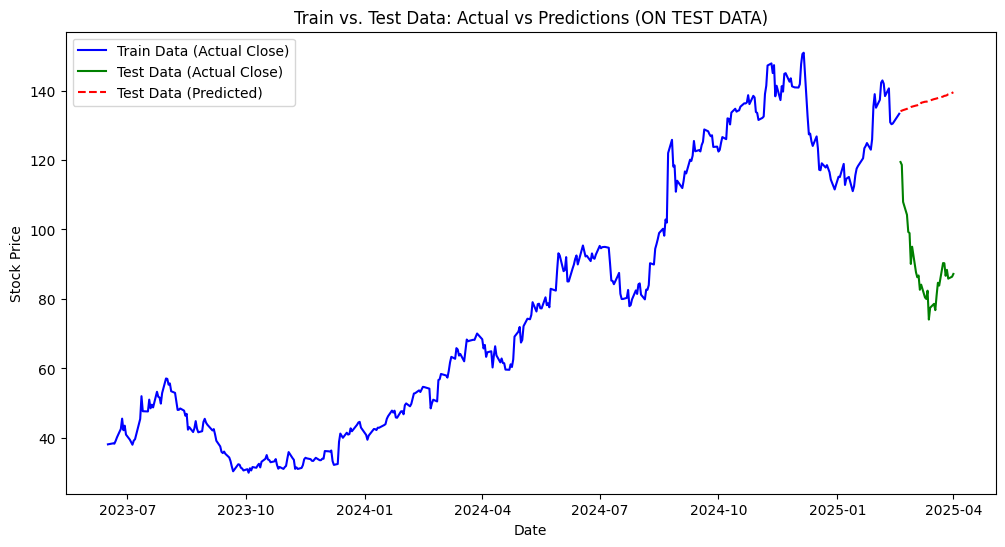

Mean Squared Error (MSE): 2409.3572
Root Mean Squared Error (RMSE): 49.0852
Mean Absolute Percentage Error (MAPE): 55.54%
Mean Absolute Percentage Error (BIAS): 55.54%


In [50]:
from sklearn.linear_model import LinearRegression

test_length = 30
lag_value = days_of_trading_to_predict + 1

lin_reg_df = df_to_model.copy()

## Adding Time Features
reference_date_train = lin_reg_df.index.min()
time_diff = reference_date_train - lin_reg_df.index
lin_reg_df['days_past'] = time_diff.days
lin_reg_df['months_past'] = time_diff.days // 30  # Approximation of months
lin_reg_df['years_past'] = time_diff.days // 365  # Approximation of years
lin_reg_df[['days_past', 'months_past', 'years_past']] = lin_reg_df[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

# Adding Lag Features
lin_reg_df[f'lag_{lag_value}'] = lin_reg_df['Close'].shift(lag_value).fillna(0)

## Creating train & test
test_data = lin_reg_df.tail(test_length).copy()
first_test_date = test_data.index[0] # To make train

# Train Data
train_data = lin_reg_df[lin_reg_df.index < first_test_date].copy()

X_train = train_data[['days_past', 'months_past', 'years_past', 'lag_101']]
y_train = train_data['Close']  

X_test = test_data[['days_past', 'months_past', 'years_past', 'lag_101']]
y_test = test_data['Close']  

model = LinearRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
test_data['preds'] = y_pred

# Plot results
plot_train_test(train_data, test_data)

# Display performance metrics
display_metrics(test_data)

Regression Equation:
Close = -3.2251 + (0.1288 * days_past) + (1.3285 * months_past) + (30.9174 * years_past) + (-0.3955 * lag_101)


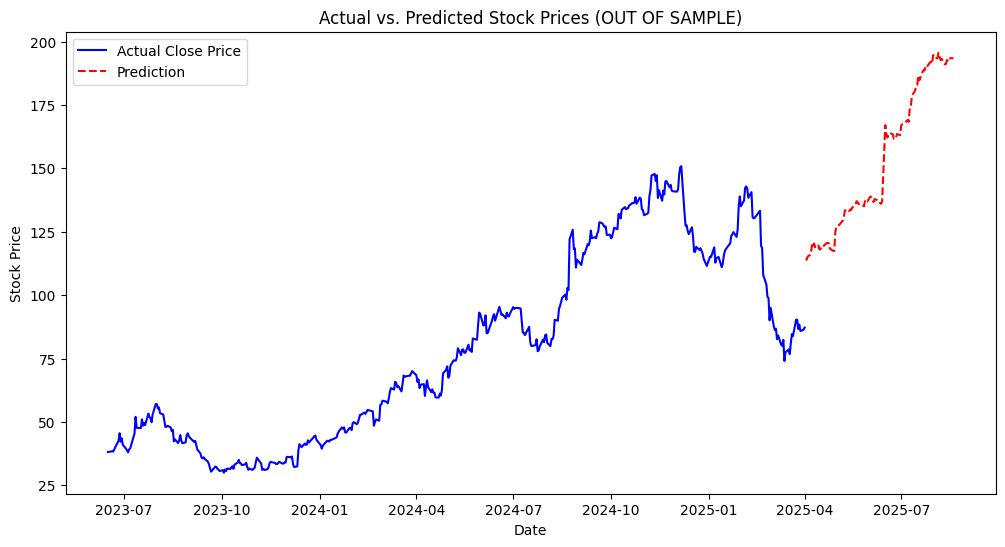

In [51]:
## Out of Sample
## Create the predictions dataset
predictions_df_lin_reg = predictions_df.copy()

reference_date_train = lin_reg_df.index.min()

## Creating the Train set
time_diff = reference_date_train - df_to_model.index
df_to_model['days_past'] = time_diff.days
df_to_model['months_past'] = time_diff.days // 30  # Approximation of months
df_to_model['years_past'] = time_diff.days // 365  # Approximation of years
df_to_model[['days_past', 'months_past', 'years_past']] = df_to_model[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

# Adding Lag Features
df_to_model[f'lag_{lag_value}'] = df_to_model['Close'].shift(lag_value).fillna(0)

## Feature creation for the predictions
predictions_df_lin_reg['dt'] = pd.to_datetime(predictions_df_lin_reg['dt'])
predictions_df_lin_reg['dt'] = predictions_df_lin_reg['dt'].dt.date
reference_date = pd.to_datetime(reference_date_train).date()
time_diff = reference_date - predictions_df_lin_reg['dt']

predictions_df_lin_reg['days_past'] = time_diff.dt.days
predictions_df_lin_reg['months_past'] = time_diff.dt.days // 30  # Approximation of months
predictions_df_lin_reg['years_past'] = time_diff.dt.days // 365  # Approximation of years
predictions_df_lin_reg[['days_past', 'months_past', 'years_past']] = predictions_df_lin_reg[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

# Adding Lag Features
predictions_df_lin_reg[f'lag_{lag_value}'] = df_to_model['Close'].iloc[-len(predictions_df_lin_reg):].values

#Spliting into X & y, training, and predicting
X_train = df_to_model[['days_past', 'months_past', 'years_past', 'lag_101']]
y_train = df_to_model['Close']  

X_forecast = predictions_df_lin_reg[['days_past', 'months_past', 'years_past', 'lag_101']]

model = LinearRegression()
model.fit(X_train, y_train)


# Get coefficients and intercept
coefficients = model.coef_
intercept = model.intercept_

# Print equation
feature_names = ['days_past', 'months_past', 'years_past', 'lag_101']
equation = f"Close = {intercept:.4f}"

for coef, feature in zip(coefficients, feature_names):
    equation += f" + ({coef:.4f} * {feature})"

print("Regression Equation:")
print(equation)


y_pred = model.predict(X_forecast)
predictions_df_lin_reg['preds'] = y_pred


## Plotting Predictions
plot_oos(df_to_model, predictions_df_lin_reg)

## XGBoost

In [52]:
## Adding 'day' did nothing

-- Features to try

- Day (dt.day)... day of the month
- pct_change (lags) 
-  Volatilty ex. train_data['Volatility'] = train_data['Close'].rolling(window=20).std()

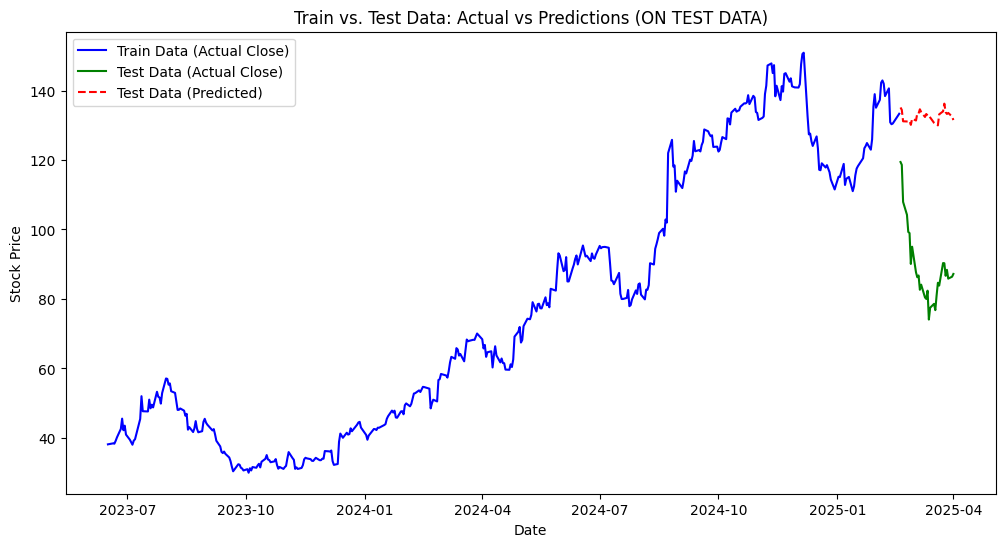

Mean Squared Error (MSE): 1996.6336
Root Mean Squared Error (RMSE): 44.6837
Mean Absolute Percentage Error (MAPE): 50.59%
Mean Absolute Percentage Error (BIAS): 50.59%


In [53]:
import xgboost as xgb

test_length = 30
lag_value = days_of_trading_to_predict + 1
lag_value2 = (days_of_trading_to_predict *2) + 1

xgboost_df = df_to_model.copy()

## Adding Time Features
reference_date_train = xgboost_df.index.min()
time_diff = reference_date_train - xgboost_df.index
xgboost_df['days_past'] = time_diff.days
xgboost_df['months_past'] = time_diff.days // 30  # Approximation of months
xgboost_df['years_past'] = time_diff.days // 365  # Approximation of years
xgboost_df[['days_past', 'months_past', 'years_past']] = xgboost_df[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

xgboost_df['month'] = xgboost_df.index.month
xgboost_df['day'] = xgboost_df.index.day
xgboost_df["day_of_week"] = xgboost_df.index.weekday

# Adding Lag Features
xgboost_df[f'lag_{lag_value}'] = xgboost_df['Close'].shift(lag_value).fillna(0)
xgboost_df[f'lag_{lag_value2}'] = xgboost_df['Close'].shift(lag_value2).fillna(0)

xgboost_df[f'lag_{lag_value}_volume'] = xgboost_df['Volume'].shift(lag_value).fillna(0)
xgboost_df[f'lag_{lag_value2}_volume'] = xgboost_df['Volume'].shift(lag_value2).fillna(0)

## Creating train & test
test_data = xgboost_df.tail(test_length).copy()
first_test_date = test_data.index[0] # To make train

# Train Data
train_data = xgboost_df[xgboost_df.index < first_test_date].copy()

#X_train = train_data[['days_past', 'months_past', 'years_past', f'lag_{lag_value}', f'lag_{lag_value2}', 'month']]
X_train = train_data[['days_past', 'months_past', 'years_past', f'lag_{lag_value}', f'lag_{lag_value2}', 'month',f'lag_{lag_value}_volume', f'lag_{lag_value2}_volume', 'day_of_week', 'day']]
y_train = train_data['Close']  

#X_test = test_data[['days_past', 'months_past', 'years_past', f'lag_{lag_value}', f'lag_{lag_value2}', 'month', ]]
X_test = test_data[['days_past', 'months_past', 'years_past', f'lag_{lag_value}', f'lag_{lag_value2}', 'month', f'lag_{lag_value}_volume', f'lag_{lag_value2}_volume', 'day_of_week', 'day']]
y_test = test_data['Close']  

model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
xgboost_test_preds = y_pred
test_data['preds'] = y_pred

# Plot results
plot_train_test(train_data, test_data)

# Display performance metrics
display_metrics(test_data)

In [54]:
xgboost_df

,Close,Volume,SMA_20,days_past,months_past,years_past,lag_101,month,day,day_of_week,lag_201,lag_101_volume,lag_201_volume
Date,,,,,,,,,,,,,
2023-06-16 00:00:00-04:00,38.150002,8413400,NaN,0,0,0,0.000000,6,16,4,0.000000,0.0,0.0
2023-06-20 00:00:00-04:00,38.430000,1602700,NaN,4,1,1,0.000000,6,20,1,0.000000,0.0,0.0
2023-06-21 00:00:00-04:00,38.340000,738600,NaN,5,1,1,0.000000,6,21,2,0.000000,0.0,0.0
2023-06-22 00:00:00-04:00,39.160000,2365600,NaN,6,1,1,0.000000,6,22,3,0.000000,0.0,0.0
2023-06-23 00:00:00-04:00,40.150002,1117200,NaN,7,1,1,0.000000,6,23,4,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-03-26 00:00:00-04:00,86.669998,2887700,83.9540,649,22,2,138.470001,3,26,2,92.040001,1917300.0,2995900.0
2025-03-27 00:00:00-04:00,88.389999,6143600,83.8695,650,22,2,138.000000,3,27,3,85.040001,1644200.0,7824900.0
2025-03-28 00:00:00-04:00,85.849998,14361000,83.4105,651,22,2,133.820007,3,28,4,85.040001,2132700.0,3153900.0


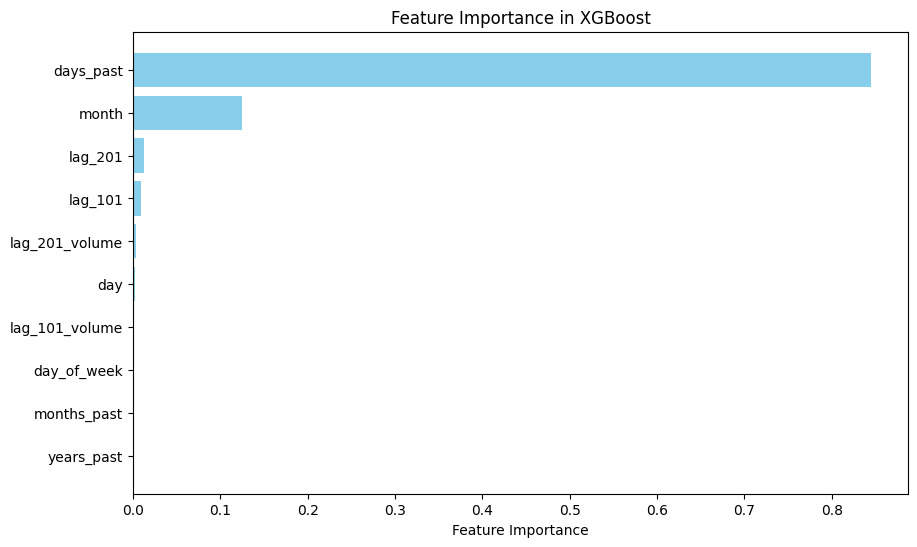

In [55]:
importance = model.feature_importances_

# Create a DataFrame to store the feature names and their importance
feature_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importance
})

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'], feature_importance_df['Importance'], color='skyblue')
plt.xlabel('Feature Importance')
plt.title('Feature Importance in XGBoost')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

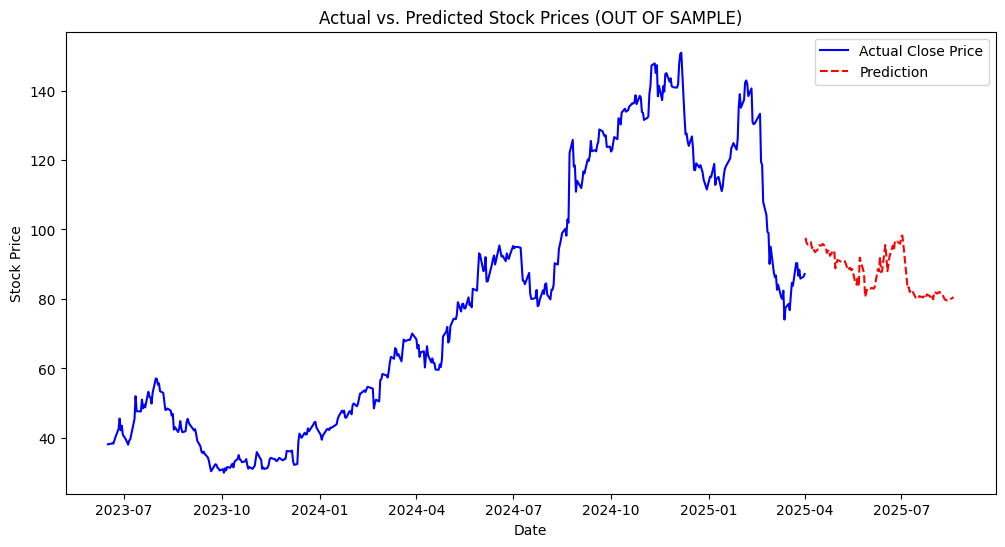

In [ ]:
## Out of Sample
## Create the predictions dataset

## OUT OF SAMPLE
predictions_df_xgboost = predictions_df.copy()

reference_date_train = xgboost_df.index.min()

## Creating the Train set
time_diff = reference_date_train - df_to_model.index
df_to_model['days_past'] = time_diff.days
df_to_model['months_past'] = time_diff.days // 30  # Approximation of months
df_to_model['years_past'] = time_diff.days // 365  # Approximation of years
df_to_model[['days_past', 'months_past', 'years_past']] = df_to_model[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

df_to_model['month'] = df_to_model.index.month
df_to_model['day'] = df_to_model.index.day
df_to_model["day_of_week"] = df_to_model.index.weekday

# Adding Lag Features
df_to_model[f'lag_{lag_value}'] = df_to_model['Close'].shift(lag_value).fillna(0)
df_to_model[f'lag_{lag_value2}'] = df_to_model['Close'].shift(lag_value2).fillna(0)

df_to_model[f'lag_{lag_value}_volume'] = df_to_model['Volume'].shift(lag_value).fillna(0)
df_to_model[f'lag_{lag_value2}_volume'] = df_to_model['Volume'].shift(lag_value2).fillna(0)




## Feature creation for the predictions
predictions_df_xgboost['dt'] = pd.to_datetime(predictions_df_xgboost['dt'])
predictions_df_xgboost['dt'] = predictions_df_xgboost['dt'].dt.date
reference_date = pd.to_datetime(reference_date_train).date()
time_diff = reference_date - predictions_df_xgboost['dt']

predictions_df_xgboost['days_past'] = time_diff.dt.days
predictions_df_xgboost['months_past'] = time_diff.dt.days // 30  # Approximation of months
predictions_df_xgboost['years_past'] = time_diff.dt.days // 365  # Approximation of years
predictions_df_xgboost[['days_past', 'months_past', 'years_past']] = predictions_df_xgboost[['days_past', 'months_past', 'years_past']].apply(lambda x: x.abs())

predictions_df_xgboost['dt'] = pd.to_datetime(predictions_df_xgboost['dt'])
predictions_df_xgboost['month'] = predictions_df_xgboost['dt'].dt.month
predictions_df_xgboost['day'] = predictions_df_xgboost['dt'].dt.day
predictions_df_xgboost['day_of_week'] = predictions_df_xgboost['dt'].dt.weekday


# Adding Lag Features
predictions_df_xgboost[f'lag_{lag_value}'] = df_to_model['Close'].shift(lag_value).iloc[-len(predictions_df_xgboost):].values
predictions_df_xgboost[f'lag_{lag_value2}'] = df_to_model['Close'].shift(lag_value2).iloc[-len(predictions_df_xgboost):].values

predictions_df_xgboost[f'lag_{lag_value}_volume'] = df_to_model['Volume'].shift(lag_value).fillna(0)
predictions_df_xgboost[f'lag_{lag_value2}_volume'] = df_to_model['Volume'].shift(lag_value2).fillna(0)

X_train = df_to_model[['days_past', 'months_past', 'years_past', f'lag_{lag_value}', f'lag_{lag_value2}', 'month',f'lag_{lag_value}_volume', f'lag_{lag_value2}_volume', 'day', 'day_of_week']]
y_train = df_to_model['Close']  

X_forecast = predictions_df_xgboost[['days_past', 'months_past', 'years_past', f'lag_{lag_value}', f'lag_{lag_value2}', 'month',f'lag_{lag_value}_volume', f'lag_{lag_value2}_volume', 'day', 'day_of_week']]

model = xgb.XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=3)
model.fit(X_train, y_train)

y_pred = model.predict(X_forecast)
predictions_df_xgboost['preds'] = y_pred


## Plotting Predictions
plot_oos(df_to_model, predictions_df_xgboost)

## Ensemble

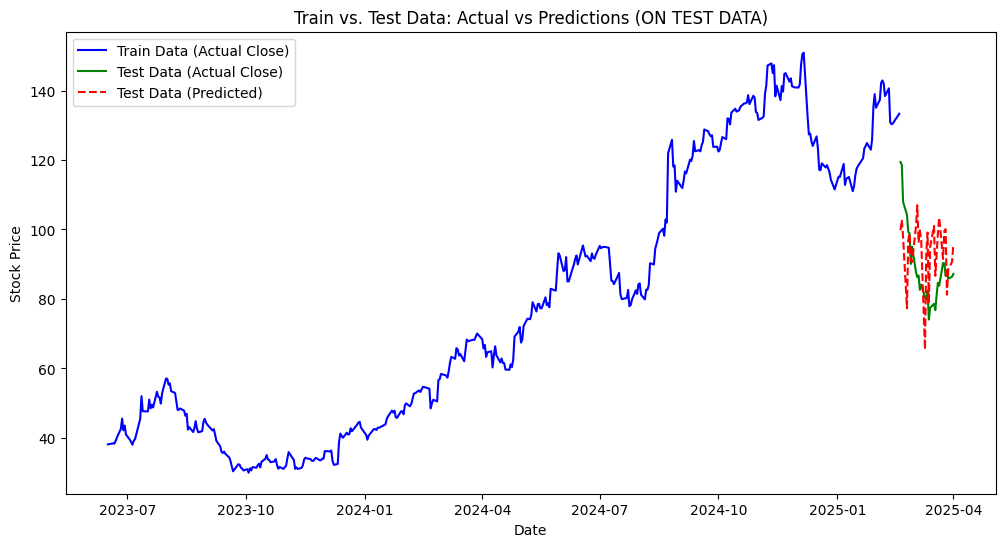

Mean Squared Error (MSE): 179.9986
Root Mean Squared Error (RMSE): 13.4164
Mean Absolute Percentage Error (MAPE): 13.10%
Mean Absolute Percentage Error (BIAS): 13.10%


In [57]:
## TEST
xgboost_weight = .85
naive_weight = .15

predictions_df_naive_test = test_df_naive['preds']
xgboost_test_preds

test_data['preds'] = (xgboost_weight * predictions_df_naive_test) + (naive_weight * xgboost_test_preds)

# Plot results
plot_train_test(train_data, test_data)

# Display performance metrics
display_metrics(test_data)

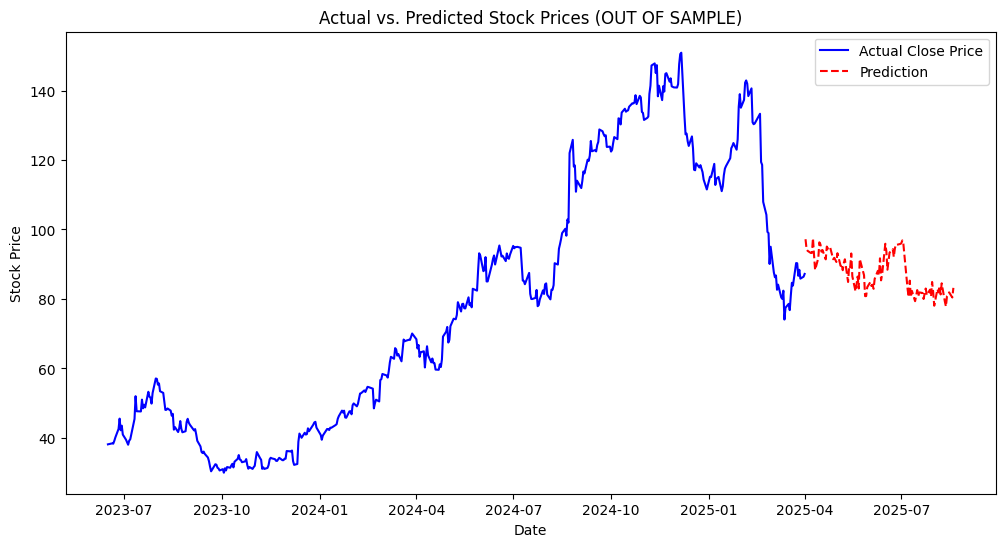

In [58]:
## OUT OF SAMPLE

xgboost_weight = .85
naive_weight = .15

predictions_df_ensemble = pd.DataFrame()
predictions_df_ensemble['dt'] = predictions_df_xgboost['dt']
predictions_df_ensemble['preds'] = (xgboost_weight * predictions_df_xgboost['preds']) + (naive_weight * predictions_df_naive['preds'])
plot_oos(df_to_model, predictions_df_ensemble)